# Emotion Classification of Given Text: Major Project

## Plan Of Attack

1. Importing all dependencies and dataset

2. Analyzing the data by performing data analysis

3. Perform required feature engineering to make the input data suitable for Deep learning models

4. Build and Train different Deep learning model

5. Evaluation of different models

6. Predictive system for custom data prediction

# 1. Importing the necessary dependencies

In [44]:
# Importing the dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score

import nltk
import re

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences,to_categorical
from keras.models import Sequential
from keras.layers import Dense,Embedding,SimpleRNN,LSTM,GRU,Bidirectional

import warnings
warnings.filterwarnings('ignore')  # To ignore warnings

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-dataset/validation.csv
/kaggle/input/emotion-dataset/training.csv
/kaggle/input/emotion-dataset/test.csv


In [3]:
train_data = pd.read_csv("/kaggle/input/emotion-dataset/training.csv") # Importing the train dataset
test_data = pd.read_csv("/kaggle/input/emotion-dataset/test.csv")   # Importing the test dataset
validation_data = pd.read_csv("/kaggle/input/emotion-dataset/validation.csv")  # Importing the validation dataset

# 2. Performing the Data Analysis (Including Exploratory Data Analysis)

In [4]:
print("Train data :\n",train_data.head(),"\n")  # Printing the train dataset
print("Test data :\n",test_data.head(),"\n")   # Printing the test dataset
print("Validation data :\n",validation_data.head(),"\n")  # Printing the validation dataset

Train data :
                                                 text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3 

Test data :
                                                 text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0 

Validation data :
                                                 text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful serva

In [5]:
print("Train Data shape: ",train_data.shape) #Printing the shape train data
print("Test Data shape: ",test_data.shape) #Printing the shape test data
print("Validation Data shape: ",validation_data.shape) #Printing the shape validation data

Train Data shape:  (16000, 2)
Test Data shape:  (2000, 2)
Validation Data shape:  (2000, 2)


In [6]:
## Performing the EDA for the training dataset only
print(train_data.info()) # Information about training dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB
None


In [7]:
print(train_data.describe()) # Describeing the numerical data of training dataset

              label
count  16000.000000
mean       1.565937
std        1.501430
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max        5.000000


In [8]:
print(train_data.describe(include = 'O')) # Describeing the non-numerical data of training dataset

                                                     text
count                                               16000
unique                                              15969
top     i feel on the verge of tears from weariness i ...
freq                                                    2


In [9]:
train_data['label'].value_counts() # Counting the number of positive and negative sentiments of the training dataset

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

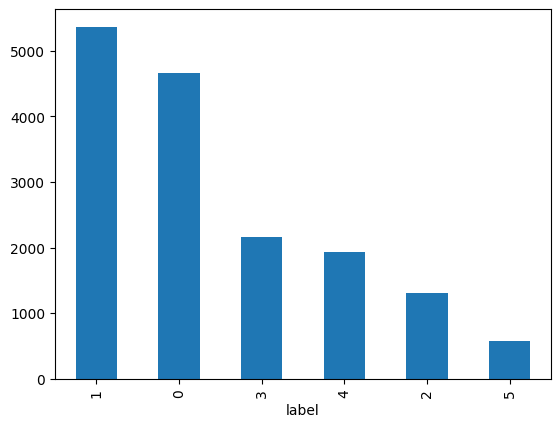

In [10]:
train_data['label'].value_counts().plot(kind = 'bar') # Plotting the bar plot for visualizing the countness of positive and negative labels
plt.show()

# 3. Feature Engineering 

In [11]:
print("The Null value rows present in the trianing dataset is : ",train_data.isna().sum())    # Printing the null value present in the training dataset
print("The Duplicate rows present in the training dataset is : ",train_data.duplicated().sum())   # Printing the duplicated value present in the training dataset

The Null value rows present in the trianing dataset is :  text     0
label    0
dtype: int64
The Duplicate rows present in the training dataset is :  1


In [12]:
train_data.drop_duplicates(keep = 'first',inplace=True) # Dropping the duplicated values and keeping the first value in the dataset

In [13]:
print("Now the Duplicate rows present in the training dataset is : ",train_data.duplicated().sum()) # After Dropping now the duplicated values are zero
print("Now the shape of the training dataset is ",train_data.shape) # After dropping the duplicates the rows of the training data reduce

Now the Duplicate rows present in the training dataset is :  0
Now the shape of the training dataset is  (15999, 2)


In [14]:
## Perfoming the text preprocessing

nltk.download('stopwords')  # Downloading all the stopwords from the nltk library
pattern = re.compile('<.*?>')  # Pattern for removing the HTML tags
punctuation = string.punctuation   # Extracting all punctuation from the string library
ps = PorterStemmer()  # Creating a PorterStemmer object for the stemming purpose
tokenizer = Tokenizer() # Creating a Tokenizer object for representing the text into numeric form

def text_preprocess(text):

  text = re.sub(pattern,'',text)  # Removing the HTML tags using re library

  text = text.lower()  # Lower case all the character present in the text

  text = text.translate(str.maketrans('','',punctuation))   # Removing all the punctuation from the text

  text = text.split()    # word tokenize the text

  text = [ps.stem(word) for word in text if word not in stopwords.words('english')]  # Removing the stopwords from the text and stem each word

  return ' '.join(text)  # Join each word for the formation of clear text in string form


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
processed_train_data = [text_preprocess(words) for words in train_data['text']]   # Applying the text pre-processing fuction to the text column of train dataset
processed_validation_data = [text_preprocess(words) for words in validation_data['text']]  # Applying the text pre-processing fuction to the text column of validation dataset
processed_test_data = [text_preprocess(words) for words in test_data['text']]   # Applying the text pre-processing fuction to the text column of test dataset

In [16]:
# Putting all the processed text of train data into a whole text. Then fit this whole text into the tokenizer for word embedding.

whole_text = ''

for i in processed_train_data:
  whole_text = whole_text + i


tokenizer.fit_on_texts([whole_text])
print(len(tokenizer.word_index))   # Printing the vocab size or the number of words present in the train data text. This is used as hyperparameter for the embedding layer.

20360


In [17]:
# In this cell the train processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_train_sequences = []

for i in processed_train_data:
  x_train_sequences.append(tokenizer.texts_to_sequences([i])[0])  # Each processed text is converted into sequences 


x_train_padseq = pad_sequences(x_train_sequences,maxlen = 50, padding = 'post')  # Each sequences are padded to have equal size.

x_train = np.array(x_train_padseq)
y_train = np.array(to_categorical(train_data['label']))

In [18]:
# In this cell the validation processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_validation_sequences = []

for i in processed_validation_data:
  x_validation_sequences.append(tokenizer.texts_to_sequences([i])[0])    # Each processed text is converted into sequences


x_validation_padseq = pad_sequences(x_validation_sequences,maxlen = 50, padding = 'post')    # Each sequences are padded to have equal size.

x_validation = np.array(x_validation_padseq)
y_validation = np.array(to_categorical(validation_data['label']))

In [19]:
# In this cell the test processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_test_sequences = []

for i in processed_test_data:
  x_test_sequences.append(tokenizer.texts_to_sequences([i])[0])     # Each processed text is converted into sequences


x_test_padseq = pad_sequences(x_test_sequences,maxlen = 50, padding = 'post')    # Each sequences are padded to have equal size.

x_test = np.array(x_test_padseq)
y_test = np.array(test_data['label'])

# 4. Model Building and Model Training

In [20]:
## Defining the hyperparameter of the embedding layer

vocab_size = 20360   # vocabulary size of the tokenizer
dim = 50             # Number of dense vector dimension required for the output
sent_length = 50    # The length of each sequence

In [21]:
## Bidirectional LSTM model

bidirectional_lstm_model = Sequential()

bidirectional_lstm_model.add(Embedding(vocab_size,dim,input_length = sent_length))
bidirectional_lstm_model.add(Bidirectional(LSTM(100)))
bidirectional_lstm_model.add(Dense(6,activation = 'softmax'))

bidirectional_lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

bidirectional_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1018000   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              120800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 1206      
                                                                 
Total params: 1,140,006
Trainable params: 1,140,006
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Training the Bidirectional LSTM model

bidirectional_lstm_model_history = bidirectional_lstm_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 [==============================] - 39s 57ms/step - loss: 1.1215 - accuracy: 0.5759 - val_loss: 0.5432 - val_accuracy: 0.8080
Epoch 2/5
500/500 [==============================] - 6s 12ms/step - loss: 0.3035 - accuracy: 0.8950 - val_loss: 0.3427 - val_accuracy: 0.8750
Epoch 3/5
500/500 [==============================] - 6s 13ms/step - loss: 0.1588 - accuracy: 0.9436 - val_loss: 0.3143 - val_accuracy: 0.8905
Epoch 4/5
500/500 [==============================] - 5s 10ms/step - loss: 0.1061 - accuracy: 0.9631 - val_loss: 0.3495 - val_accuracy: 0.8805
Epoch 5/5
500/500 [==============================] - 5s 10ms/step - loss: 0.0815 - accuracy: 0.9706 - val_loss: 0.4003 - val_accuracy: 0.8800


In [23]:
# LSTM model

lstm_model = Sequential()

lstm_model.add(Embedding(vocab_size,dim,input_length = sent_length))
lstm_model.add(LSTM(100,activation='relu'))
lstm_model.add(Dense(6,activation = 'softmax'))

lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            1018000   
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 1,079,006
Trainable params: 1,079,006
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Train the LSTM model

lstm_model_history = lstm_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 [==============================] - 45s 89ms/step - loss: 0.8936 - accuracy: 0.6861 - val_loss: 1.2967 - val_accuracy: 0.5835
Epoch 2/5
500/500 [==============================] - 44s 89ms/step - loss: 0.8364 - accuracy: 0.7151 - val_loss: 1.3314 - val_accuracy: 0.5845
Epoch 3/5
500/500 [==============================] - 44s 88ms/step - loss: 0.7855 - accuracy: 0.7332 - val_loss: 1.3262 - val_accuracy: 0.5905
Epoch 4/5
500/500 [==============================] - 43s 86ms/step - loss: 0.7482 - accuracy: 0.7474 - val_loss: 1.2980 - val_accuracy: 0.5965
Epoch 5/5
500/500 [==============================] - 43s 86ms/step - loss: 0.7001 - accuracy: 0.7637 - val_loss: 1.2913 - val_accuracy: 0.5950


In [25]:
# Stacked LSTM model

stack_lstm_model = Sequential()

stack_lstm_model.add(Embedding(vocab_size,dim,input_length = sent_length))
stack_lstm_model.add(LSTM(100,return_sequences = True))
stack_lstm_model.add(LSTM(100,return_sequences = True))
stack_lstm_model.add(LSTM(50))
stack_lstm_model.add(Dense(6,activation = 'softmax'))

stack_lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

stack_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            1018000   
                                                                 
 lstm_2 (LSTM)               (None, 50, 100)           60400     
                                                                 
 lstm_3 (LSTM)               (None, 50, 100)           80400     
                                                                 
 lstm_4 (LSTM)               (None, 50)                30200     
                                                                 
 dense_2 (Dense)             (None, 6)                 306       
                                                                 
Total params: 1,189,306
Trainable params: 1,189,306
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Train the stack LSTM Model

stack_lstm_model_history = stack_lstm_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 [==============================] - 6s 11ms/step - loss: 1.5766 - accuracy: 0.3351 - val_loss: 1.5815 - val_accuracy: 0.3520
Epoch 2/5
500/500 [==============================] - 5s 11ms/step - loss: 1.5770 - accuracy: 0.3351 - val_loss: 1.5848 - val_accuracy: 0.3520
Epoch 3/5
500/500 [==============================] - 6s 11ms/step - loss: 1.5765 - accuracy: 0.3331 - val_loss: 1.5817 - val_accuracy: 0.3520
Epoch 4/5
500/500 [==============================] - 6s 12ms/step - loss: 1.5766 - accuracy: 0.3351 - val_loss: 1.5799 - val_accuracy: 0.3520
Epoch 5/5
500/500 [==============================] - 6s 11ms/step - loss: 1.5765 - accuracy: 0.3351 - val_loss: 1.5823 - val_accuracy: 0.3520


In [27]:
# GRU model
gru_model = Sequential()

gru_model.add(Embedding(vocab_size,dim,input_length = sent_length))
gru_model.add(GRU(100))
gru_model.add(Dense(6,activation = 'softmax'))

gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 50)            1018000   
                                                                 
 gru (GRU)                   (None, 100)               45600     
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 1,064,206
Trainable params: 1,064,206
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Train the GRU model

gru_model_history = gru_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 [==============================] - 4s 7ms/step - loss: 1.5764 - accuracy: 0.3328 - val_loss: 1.5832 - val_accuracy: 0.3520
Epoch 2/5
500/500 [==============================] - 3s 7ms/step - loss: 1.5769 - accuracy: 0.3351 - val_loss: 1.5842 - val_accuracy: 0.3520
Epoch 3/5
500/500 [==============================] - 3s 6ms/step - loss: 1.5770 - accuracy: 0.3351 - val_loss: 1.5845 - val_accuracy: 0.3520
Epoch 4/5
500/500 [==============================] - 3s 7ms/step - loss: 1.5771 - accuracy: 0.3351 - val_loss: 1.5812 - val_accuracy: 0.3520
Epoch 5/5
500/500 [==============================] - 3s 6ms/step - loss: 1.5763 - accuracy: 0.3351 - val_loss: 1.5830 - val_accuracy: 0.3520


In [29]:
# Bidirectional GRU model

bidirectional_gru_model = Sequential()

bidirectional_gru_model.add(Embedding(vocab_size,dim,input_length = sent_length))
bidirectional_gru_model.add(Bidirectional(GRU(100)))
bidirectional_gru_model.add(Dense(6,activation = 'softmax'))

bidirectional_gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

bidirectional_gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 50)            1018000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              91200     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 1,110,406
Trainable params: 1,110,406
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Train the bidirectional GRU model

bidirectional_gru_model_history = bidirectional_gru_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 [==============================] - 25s 42ms/step - loss: 0.9839 - accuracy: 0.6347 - val_loss: 0.4600 - val_accuracy: 0.8435
Epoch 2/5
500/500 [==============================] - 6s 12ms/step - loss: 0.2742 - accuracy: 0.9029 - val_loss: 0.2973 - val_accuracy: 0.8835
Epoch 3/5
500/500 [==============================] - 5s 9ms/step - loss: 0.1539 - accuracy: 0.9416 - val_loss: 0.3132 - val_accuracy: 0.8860
Epoch 4/5
500/500 [==============================] - 5s 10ms/step - loss: 0.1077 - accuracy: 0.9582 - val_loss: 0.3424 - val_accuracy: 0.8885
Epoch 5/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0806 - accuracy: 0.9692 - val_loss: 0.3806 - val_accuracy: 0.8815


In [31]:
# Stacked GRU model

stack_gru_model = Sequential()

stack_gru_model.add(Embedding(vocab_size,dim,input_length = sent_length))
stack_gru_model.add(GRU(100,return_sequences = True))
stack_gru_model.add(GRU(100,return_sequences = True))
stack_gru_model.add(GRU(50))
stack_gru_model.add(Dense(6,activation = 'softmax'))

stack_gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

stack_gru_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 50)            1018000   
                                                                 
 gru_2 (GRU)                 (None, 50, 100)           45600     
                                                                 
 gru_3 (GRU)                 (None, 50, 100)           60600     
                                                                 
 gru_4 (GRU)                 (None, 50)                22800     
                                                                 
 dense_5 (Dense)             (None, 6)                 306       
                                                                 
Total params: 1,147,306
Trainable params: 1,147,306
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Train the stack GRU model

stack_gru_model_history = stack_gru_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 [==============================] - 6s 12ms/step - loss: 1.5772 - accuracy: 0.3351 - val_loss: 1.5823 - val_accuracy: 0.3520
Epoch 2/5
500/500 [==============================] - 6s 11ms/step - loss: 1.5463 - accuracy: 0.3464 - val_loss: 1.2404 - val_accuracy: 0.3605
Epoch 3/5
500/500 [==============================] - 5s 11ms/step - loss: 0.6956 - accuracy: 0.7430 - val_loss: 0.3997 - val_accuracy: 0.8575
Epoch 4/5
500/500 [==============================] - 6s 11ms/step - loss: 0.2666 - accuracy: 0.9039 - val_loss: 0.2976 - val_accuracy: 0.8955
Epoch 5/5
500/500 [==============================] - 5s 10ms/step - loss: 0.1784 - accuracy: 0.9317 - val_loss: 0.2688 - val_accuracy: 0.9050


# 5. Evaluation of Models

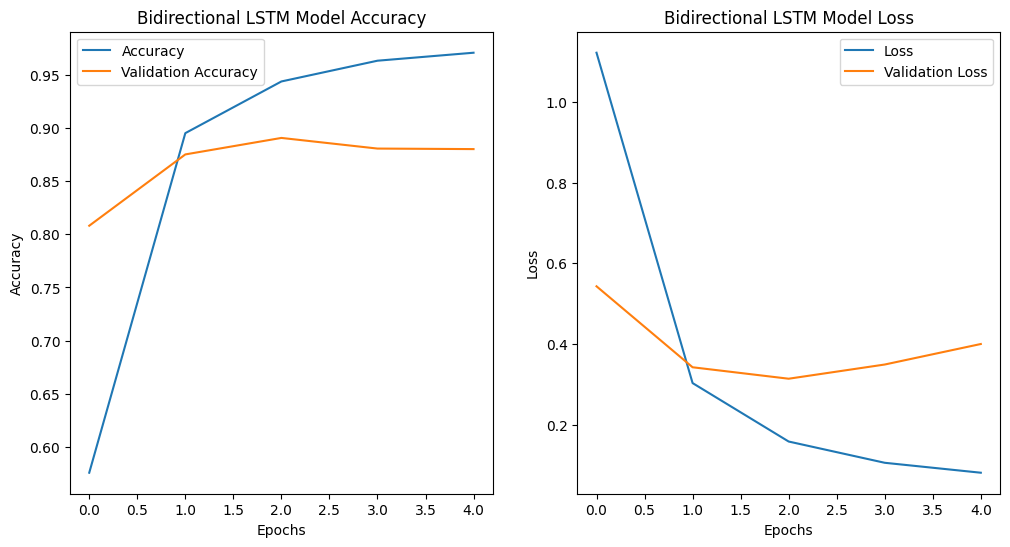

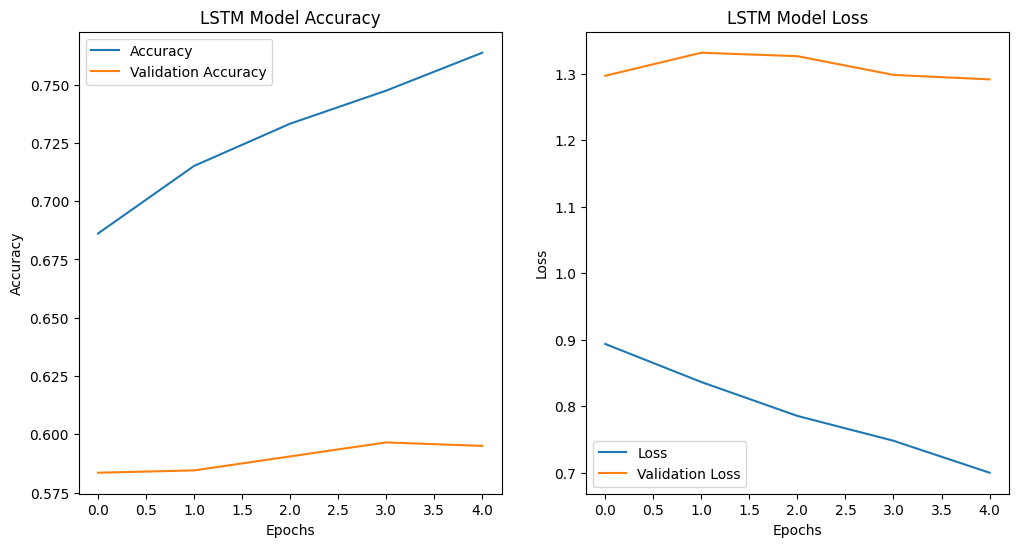

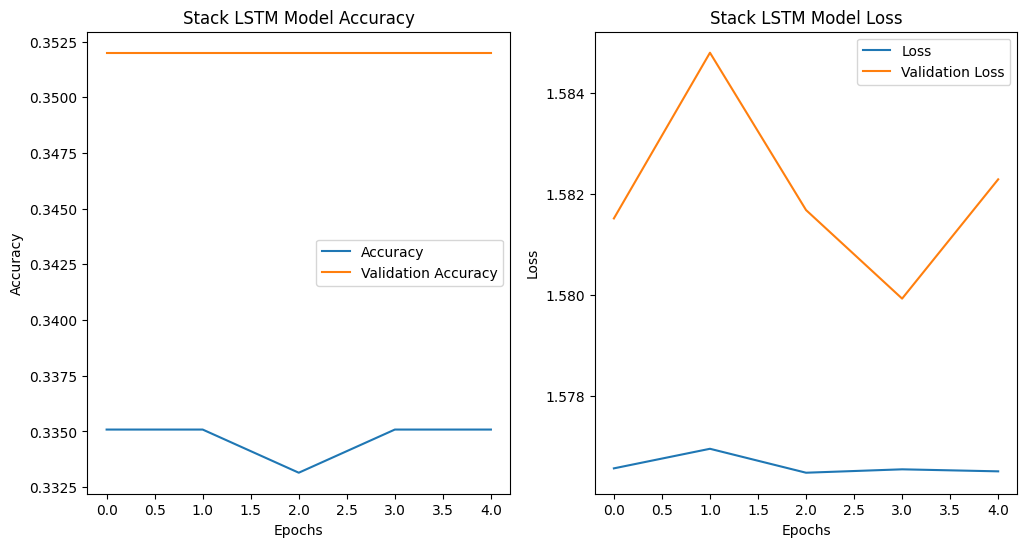

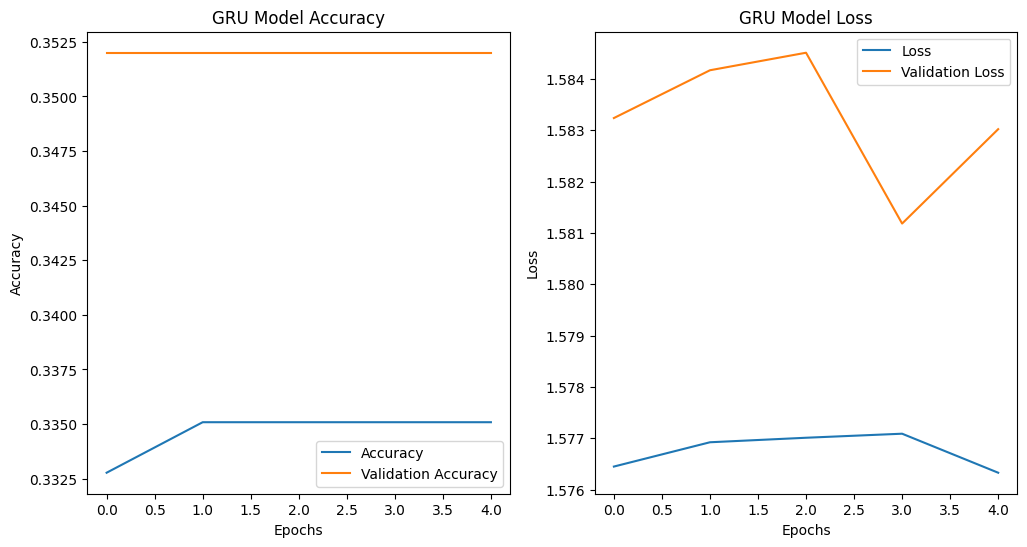

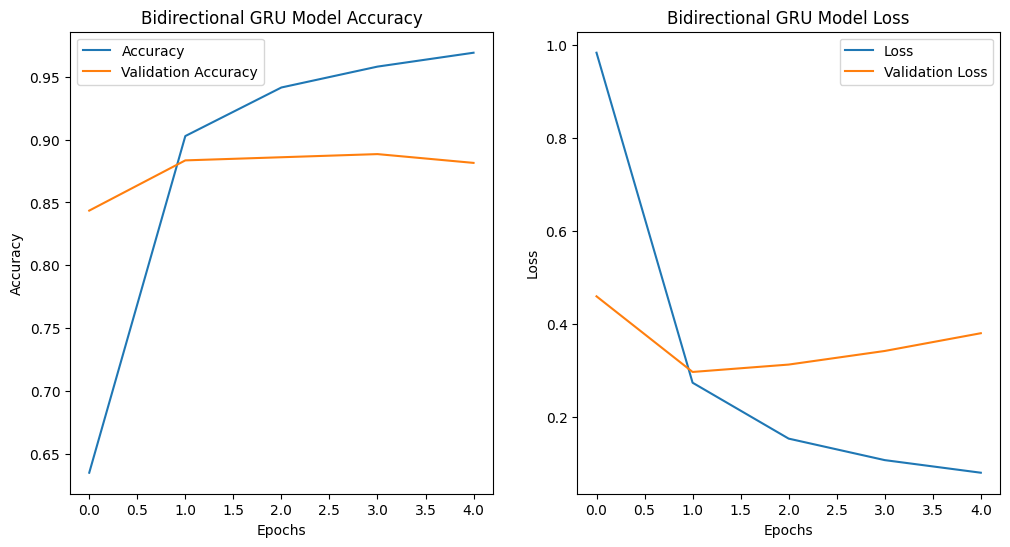

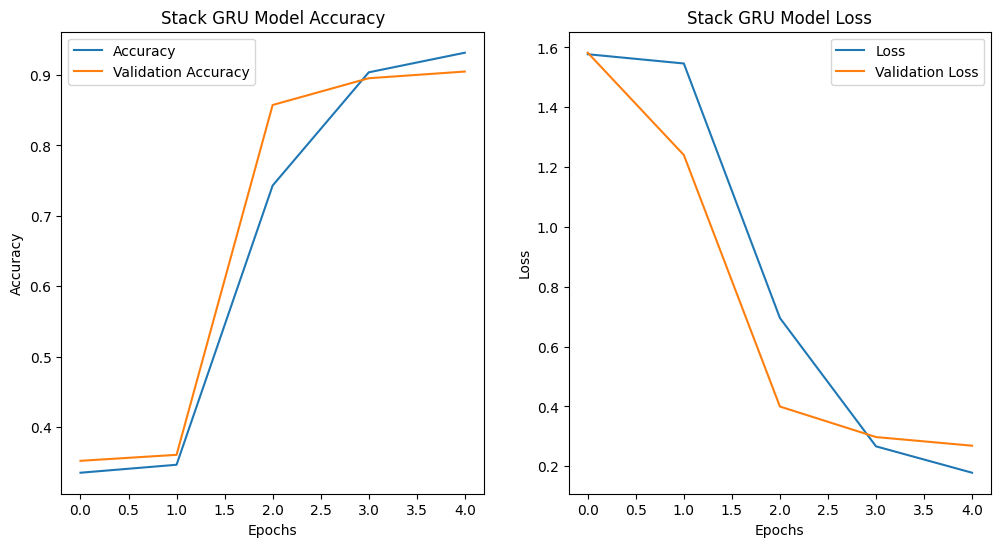

In [45]:
# Setting the figure size of the plot
plt.figure(figsize=(12,6))


# Plotting the accuracy plot of Bidirectional LSTM model
plt.subplot(1,2,1)
plt.title("Bidirectional LSTM Model Accuracy")
plt.plot(bidirectional_lstm_model_history.history['accuracy'],label='Accuracy')
plt.plot(bidirectional_lstm_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


# Plotting the loss plot of Bidirectional LSTM model
plt.subplot(1,2,2)
plt.title("Bidirectional LSTM Model Loss")
plt.plot(bidirectional_lstm_model_history.history['loss'],label='Loss')
plt.plot(bidirectional_lstm_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the accuracy plot of LSTM model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("LSTM Model Accuracy")
plt.plot(lstm_model_history.history['accuracy'],label='Accuracy')
plt.plot(lstm_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the loss plot of LSTM model
plt.subplot(1,2,2)
plt.title("LSTM Model Loss")
plt.plot(lstm_model_history.history['loss'],label='Loss')
plt.plot(lstm_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the accuracy plot of Stack LSTM model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Stack LSTM Model Accuracy")
plt.plot(stack_lstm_model_history.history['accuracy'],label='Accuracy')
plt.plot(stack_lstm_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the loss plot of Stack LSTM model
plt.subplot(1,2,2)
plt.title("Stack LSTM Model Loss")
plt.plot(stack_lstm_model_history.history['loss'],label='Loss')
plt.plot(stack_lstm_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the accuracy plot of GRU model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("GRU Model Accuracy")
plt.plot(gru_model_history.history['accuracy'],label='Accuracy')
plt.plot(gru_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the loss plot of GRU model
plt.subplot(1,2,2)
plt.title("GRU Model Loss")
plt.plot(gru_model_history.history['loss'],label='Loss')
plt.plot(gru_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the accuracy plot of Bidirectional GRU model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Bidirectional GRU Model Accuracy")
plt.plot(bidirectional_gru_model_history.history['accuracy'],label='Accuracy')
plt.plot(bidirectional_gru_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the loss plot of Bidirectional GRU model
plt.subplot(1,2,2)
plt.title("Bidirectional GRU Model Loss")
plt.plot(bidirectional_gru_model_history.history['loss'],label='Loss')
plt.plot(bidirectional_gru_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting the accuracy plot of Stack GRU model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Stack GRU Model Accuracy")
plt.plot(stack_gru_model_history.history['accuracy'],label='Accuracy')
plt.plot(stack_gru_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the loss plot of Stack GRU model
plt.subplot(1,2,2)
plt.title("Stack GRU Model Loss")
plt.plot(stack_gru_model_history.history['loss'],label='Loss')
plt.plot(stack_gru_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [47]:
# Predicting the output of each model on test data for model evaluation
# ----------------------------------------------------------------------
y_pred_bilstm = bidirectional_lstm_model.predict(x_test)
y_pred_lstm = lstm_model.predict(x_test)
y_pred_stacklstm = stack_lstm_model.predict(x_test)
y_pred_bigru = bidirectional_gru_model.predict(x_test)
y_pred_gru = gru_model.predict(x_test)
y_pred_stackgru = stack_gru_model.predict(x_test)


# Converting the continuous output model into discrete classes
# ---------------------------------------------------------------------
y_pred_bilstm = np.array([np.argmax(x) for x in y_pred_bilstm])
y_pred_lstm = np.array([np.argmax(x) for x in y_pred_lstm])
y_pred_stacklstm = np.array([np.argmax(x) for x in y_pred_stacklstm])
y_pred_bigru = np.array([np.argmax(x) for x in y_pred_bigru])
y_pred_gru = np.array([np.argmax(x) for x in y_pred_gru])
y_pred_stackgru = np.array([np.argmax(x) for x in y_pred_stackgru])

63/63 [==============================] - 0s 4ms/step


In [58]:
# Predicting the accuracy_score,f1_score,recall_score,precision_score of each model
# Then converting all the details into dataframe


result = {"Model Name":['Bidirectional LSTM',"LSTM","Stack LSTM", "Bidirectional GRU","GRU","Stack GRU"],
         "Accuracy Score":[accuracy_score(y_test,y_pred_bilstm),accuracy_score(y_test,y_pred_lstm),accuracy_score(y_test,y_pred_stacklstm),accuracy_score(y_test,y_pred_bigru),accuracy_score(y_test,y_pred_gru),accuracy_score(y_test,y_pred_stackgru)],
         "F1 Score(macro)":[f1_score(y_test,y_pred_bilstm,average='macro'),f1_score(y_test,y_pred_lstm,average='macro'),f1_score(y_test,y_pred_stacklstm,average='macro'),f1_score(y_test,y_pred_bigru,average='macro'),f1_score(y_test,y_pred_gru,average='macro'),f1_score(y_test,y_pred_stackgru,average='macro')],
         "Recall Score(macro)":[recall_score(y_test,y_pred_bilstm,average='macro'),recall_score(y_test,y_pred_lstm,average='macro'),recall_score(y_test,y_pred_stacklstm,average='macro'),recall_score(y_test,y_pred_bigru,average='macro'),recall_score(y_test,y_pred_gru,average='macro'),recall_score(y_test,y_pred_stackgru,average='macro')],
         "Precision Score(macro)":[precision_score(y_test,y_pred_bilstm,average='macro'),precision_score(y_test,y_pred_lstm,average='macro'),precision_score(y_test,y_pred_stacklstm,average='macro'),precision_score(y_test,y_pred_bigru,average='macro'),precision_score(y_test,y_pred_gru,average='macro'),precision_score(y_test,y_pred_stackgru,average='macro')],
         "F1 Score(micro)":[f1_score(y_test,y_pred_bilstm,average='micro'),f1_score(y_test,y_pred_lstm,average='micro'),f1_score(y_test,y_pred_stacklstm,average='micro'),f1_score(y_test,y_pred_bigru,average='micro'),f1_score(y_test,y_pred_gru,average='micro'),f1_score(y_test,y_pred_stackgru,average='micro')],
         "Recall Score(micro)":[recall_score(y_test,y_pred_bilstm,average='micro'),recall_score(y_test,y_pred_lstm,average='micro'),recall_score(y_test,y_pred_stacklstm,average='micro'),recall_score(y_test,y_pred_bigru,average='micro'),recall_score(y_test,y_pred_gru,average='micro'),recall_score(y_test,y_pred_stackgru,average='micro')],
         "Precision Score(micro)":[precision_score(y_test,y_pred_bilstm,average='micro'),precision_score(y_test,y_pred_lstm,average='micro'),precision_score(y_test,y_pred_stacklstm,average='micro'),precision_score(y_test,y_pred_bigru,average='micro'),precision_score(y_test,y_pred_gru,average='micro'),precision_score(y_test,y_pred_stackgru,average='micro')],}

result_df = pd.DataFrame(result)

result_df.to_excel("Report of Trained Model.xlsx")

display(result_df)

,Model Name,Accuracy Score,F1 Score(macro),Recall Score(macro),Precision Score(macro),F1 Score(micro),Recall Score(micro),Precision Score(micro)
0,Bidirectional LSTM,0.8800,0.827042,0.812756,0.851274,0.8800,0.8800,0.8800
1,LSTM,0.6245,0.413399,0.443108,0.391501,0.6245,0.6245,0.6245
2,Stack LSTM,0.3475,0.085962,0.166667,0.057917,0.3475,0.3475,0.3475
3,Bidirectional GRU,0.8795,0.832661,0.843828,0.826516,0.8795,0.8795,0.8795
4,GRU,0.3475,0.085962,0.166667,0.057917,0.3475,0.3475,0.3475
5,Stack GRU,0.8890,0.840591,0.847347,0.837427,0.8890,0.8890,0.8890


# 6. Predictive System to perform prediction on custom data

In [53]:
# Making a predictive function which takes the input as text and in output it provide the emotion of the text

def predict_emotion_of_text(text):
    
    processed_text = text_preprocess(text)
    text_to_sequence = tokenizer.texts_to_sequences([processed_text])[0]
    padded_sequence = pad_sequences([text_to_sequence],maxlen = 50, padding = 'post')
    
    prediction = bidirectional_gru_model.predict(padded_sequence)[0]    # We can use any model from  above like Bidirection LSTM, LSTM, Stack LSTM, GRU, Stack GRU Or Bidirectional GRU. As the accuracy of Bidirectional is more. So in this case I have Choose this model in predictive system.
    
    classes = ['sadness','joy','love','anger','fear','surprise']
    
    
    print("Input: ",text)
    print("Output: ",classes[np.argmax(prediction)])
    print("\n")

In [55]:
# Testing our model output with my own custom data

predict_emotion_of_text("Today is a bad day for me")
predict_emotion_of_text("she always gets angry if she doesn't get her own way")
predict_emotion_of_text("I love myself")
predict_emotion_of_text("What a beautiful day ")
predict_emotion_of_text("That horror movie is so scary")
predict_emotion_of_text("Wow! what a lovely surprise")

1/1 [==============================] - 0s 20ms/step
Input:  Today is a bad day for me
Output:  sadness


1/1 [==============================] - 0s 20ms/step
Input:  she always gets angry if she doesn't get her own way
Output:  anger


1/1 [==============================] - 0s 20ms/step
Input:  I love myself
Output:  love


1/1 [==============================] - 0s 20ms/step
Input:  What a beautiful day 
Output:  joy


1/1 [==============================] - 0s 19ms/step
Input:  That horror movie is so scary
Output:  fear


1/1 [==============================] - 0s 20ms/step
Input:  Wow! what a lovely surprise
Output:  surprise


